# Quick, Draw! 
#### Udacity project

I want to approach the question of inclusive machine learning systems by analyzing a fun, open and global data set collected by Quick, Draw! With this data set, I want to answer the following questions:

- Where do the drawings come from? 
- Are there any geographical patterns in the drawings?
- Does the Quick, Draw data set really reflect a wide spectrum of cultures and points of view or do we observe any bias?

The corresponding blog post is accessible on Medium - link

In the below notebook, I run the notebook for the different categories (Cake, Cookie, Ice Cream, Sandwich)

ote that due to the volume of data sets used from Quick Draw, there is no data stored in this repo

### Understand the data format

The data set and different preprocessed formats are explained in [Quick, Draw! github](https://github.com/googlecreativelab/quickdraw-dataset)

The raw data is available as `ndjson` files seperated by category, in the following format: 

| Key          | Type                   | Description                                  |
| ------------ | -----------------------| -------------------------------------------- |
| key_id       | 64-bit unsigned integer| A unique identifier across all drawings.     |
| word         | string                 | Category the player was prompted to draw.    |
| recognized   | boolean                | Whether the word was recognized by the game. |
| timestamp    | datetime               | When the drawing was created.                |
| countrycode  | string                 | A two letter country code ([ISO 3166-1 alpha-2](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2)) of where the player was located. |
| drawing      | string                 | A JSON array representing the vector drawing |  



The format of the drawing array is as following:
 
```javascript
[ 
  [  // First stroke 
    [x0, x1, x2, x3, ...],
    [y0, y1, y2, y3, ...],
    [t0, t1, t2, t3, ...]
  ],
  [  // Second stroke
    [x0, x1, x2, x3, ...],
    [y0, y1, y2, y3, ...],
    [t0, t1, t2, t3, ...]
  ],
  ... // Additional strokes
]
```

The Simplified Drawing format used here has simplified vectors, **no more timing information** in drawing array, and the data has been positioned and scaled into a 256x256 region.The simplification process was:

- Align the drawing to the top-left corner, to have **minimum values of 0**.
- Uniformly scale the drawing, to have **a maximum value of 255**.
- Resample all strokes with a 1 pixel spacing.
- Simplify all strokes using the Ramer–Douglas–Peucker algorithm with an epsilon value of 2.0. (which means that strokes have been simplified with fewer points than the original stroke)

### Imports

In [98]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
%matplotlib inline
py.init_notebook_mode()

### Load the data

In [99]:
%%time
# Load Simplified ndjson for the different categories. Datasets are too big to load them all at once (Notebook crashed).
category = "ice_cream" # "cake", "cookie", "sandwich"
filepath = "data/full_simplified_{}.ndjson".format(category)
df = pd.read_json(filepath, lines=True)

Wall time: 43.8 s


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123133 entries, 0 to 123132
Data columns (total 6 columns):
countrycode    123133 non-null object
drawing        123133 non-null object
key_id         123133 non-null int64
recognized     123133 non-null bool
timestamp      123133 non-null datetime64[ns]
word           123133 non-null object
dtypes: bool(1), datetime64[ns](1), int64(1), object(3)
memory usage: 4.8+ MB


In [101]:
df.head(10)

countrycode                                            drawing  \
0          IT  [[[16, 58, 84, 93, 1], [122, 255, 165, 107, 11...   
1          US  [[[54, 38, 13, 9, 15], [138, 133, 111, 94, 88]...   
2          DE  [[[12, 59, 136], [108, 109, 105]], [[8, 7, 19,...   
3          CA  [[[31, 83, 113, 114], [114, 255, 117, 90]], [[...   
4          PH  [[[30, 59, 80, 93, 115, 129, 165, 159, 106, 80...   
5          AU  [[[117, 123, 138, 140, 130, 114, 75, 42, 28, 1...   
6          GB  [[[80, 59, 41, 212, 157, 86], [255, 142, 91, 8...   
7          US  [[[19, 19, 29, 73, 100, 95, 93, 115, 107, 107,...   
8          US  [[[52, 36, 6, 0, 3, 12, 20, 51, 51, 61, 92, 10...   
9          FI  [[[3, 4, 10, 24, 37, 53, 81, 45, 0], [146, 178...   

             key_id  recognized                  timestamp       word  
0  6101352801370112        True 2017-03-12 10:45:05.275420  ice cream  
1  5869313103757312        True 2017-01-27 18:27:00.066870  ice cream  
2  6168769023967232        True 2017-03-10 21:27:58.307300  ice cream  
3  6654306302296064        True 2017-03-25 01:46:22.217980  ice cream  
4  4774113333739520        True 2017-03-16 11:47:30.762410  ice cream  
5  6199036598026240        True 2017-03-10 10:57:11.688950  ice cream  
6  5050657604108288        True 2017-03-03 19:06:15.848850  ice cream  
7  5050484060585984        True 2017-03-01 01:14:38.205750  ice cream  
8  5348758269198336        True 2017-01-23 22:41:08.207600  ice cream  
9  5219025606934528        True 2017-03-26 17:02:43.298810  ice cream

### Prepare and investigate the data
We will create several new features on top of existing data to support our investigations 

In [102]:
df['timestamp'].dt.year.unique()

array([2017], dtype=int64)

In [103]:
# Timestamp datatime checks
df.groupby(df['timestamp'].dt.month).count()

countrycode  drawing  key_id  recognized  timestamp   word
timestamp                                                            
1                41092    41092   41092       41092      41092  41092
3                82041    82041   82041       82041      82041  82041

**All drawings are timestamped January or March 2017 (for all 4 categories)**

###### Geographical information
Let's add more geographical information to be able to answer our first question around where do the doodles come from (add iso alpha 3 codes and region).

In [104]:
# Let's look at countrycode. We need real country name and ISO alpha-3 codes later on (plotly)
# Number of unique countries
df.countrycode.nunique()

173

In [105]:
# Load ISO country code - cf QuickDraw format => A two letter country code (ISO 3166-1 alpha-2)
# country_ISO.csv contains country name, alpha-2, alpha-3 and region information
# /!\ keep_default_na is set to False to avoid interpreting Namibia country code 'NA' as NaN...
ISO_countries = pd.read_csv('data/country_ISO.csv', sep=',', names=['country', 'countrycode', 'countrycode3', 'region'], header=0, keep_default_na=False)

In [106]:
ISO_countries.head(5)

country countrycode countrycode3   region
0     Afghanistan          AF          AFG     Asia
1  Ã…land Islands          AX          ALA   Europe
2         Albania          AL          ALB   Europe
3         Algeria          DZ          DZA   Africa
4  American Samoa          AS          ASM  Oceania

In [107]:
# Common values between ISO countries data set and Quick Draw dataset
ISO_countries.countrycode.isin(df.countrycode).value_counts()

True     171
False     78
Name: countrycode, dtype: int64

Some country codes are not matching.

In [108]:
# Let's merge both dataframe on countrycode using type left 
# Left means we keep every row in the left dataframe, Quick Draw dataframe here. 
# Where there are missing values on countrycode in the right dataframe, add empty / NaN values in the result.
df_c = pd.merge(df, ISO_countries, on='countrycode', how='left')

In [109]:
# Look at missing values in merged dataframe
df_c[df_c.country.isnull()].countrycode.value_counts()

ZZ    83
AN     3
Name: countrycode, dtype: int64

Looking at https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2 or https://www.iso.org/obp/ui/#search we can see that some country codes like ZZ (user-assigned code) or BU or AN have now been changed and no longer in use

In [110]:
df_c.head(5)

countrycode                                            drawing  \
0          IT  [[[16, 58, 84, 93, 1], [122, 255, 165, 107, 11...   
1          US  [[[54, 38, 13, 9, 15], [138, 133, 111, 94, 88]...   
2          DE  [[[12, 59, 136], [108, 109, 105]], [[8, 7, 19,...   
3          CA  [[[31, 83, 113, 114], [114, 255, 117, 90]], [[...   
4          PH  [[[30, 59, 80, 93, 115, 129, 165, 159, 106, 80...   

             key_id  recognized                  timestamp       word  \
0  6101352801370112        True 2017-03-12 10:45:05.275420  ice cream   
1  5869313103757312        True 2017-01-27 18:27:00.066870  ice cream   
2  6168769023967232        True 2017-03-10 21:27:58.307300  ice cream   
3  6654306302296064        True 2017-03-25 01:46:22.217980  ice cream   
4  4774113333739520        True 2017-03-16 11:47:30.762410  ice cream   

                    country countrycode3    region  
0                     Italy          ITA    Europe  
1  United States of America          USA  Americas  
2                   Germany          DEU    Europe  
3                    Canada          CAN  Americas  
4               Philippines          PHL      Asia

In [111]:
# drop rows where country = NaN
df_c = df_c.dropna(subset=['country'])
df_c.shape

(123047, 9)

In [112]:
# count and percentage of drawings per country
geo_dist_count = df_c.countrycode3.value_counts()
geo_dist_perc = (geo_dist_count/len(df_c)*100)

In [113]:
# countries with minimum of 1000 drawings for the category
geo_dist_count[geo_dist_count>=1000]

USA    52608
GBR     9101
DEU     4471
CAN     4354
AUS     2701
RUS     2664
BRA     2627
FIN     2243
SWE     2120
CZE     1995
ITA     1983
KOR     1756
SAU     1741
POL     1703
THA     1670
PHL     1630
FRA     1616
NLD     1457
HUN     1174
IDN     1065
IND     1033
Name: countrycode3, dtype: int64

In [114]:
# with plotly draw map showing countries of players and percentage of drawing per country
data = dict(
        type = 'choropleth',
        locations = geo_dist_perc.index,
        z = geo_dist_perc,
        colorbar = {'ticksuffix': '%'}  
      )

layout = dict(
    title = 'Geographical distribution - Category: {}'.format(category),
    geo = dict(
        showframe = False,
        projection = {'type':'equirectangular'}
    )
)

choromap = go.Figure(data = [data],layout = layout)
py.iplot(choromap)

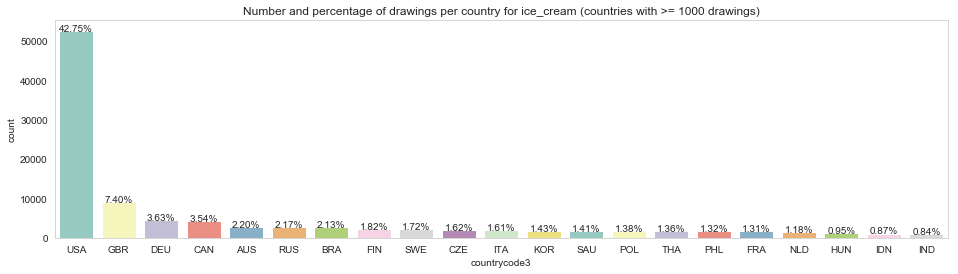

In [115]:
#show geographies and percentage of drawing with a countplot
f, ax = plt.subplots(1,1, figsize=(16,4))
total = float(len(df_c))
# select countries with minimum 1000 drawings
df_sub = df_c[df_c.countrycode3.isin(geo_dist_count[geo_dist_count>=1000].index)]
g = sns.countplot(df_sub['countrycode3'], order = df_sub['countrycode3'].value_counts().index, palette='Set3')
g.set_title("Number and percentage of drawings per country for {} (countries with >= 1000 drawings)".format(category))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

#### Let's focus on the countries with at least 1,000 drawing for each of our 4 categories (19 countries) and add new features

In [116]:
# main_countries = countries with min 1000 drawing for the category
main_countries = geo_dist_count[geo_dist_count>=1000].index
df_q2 = df_c[df_c.countrycode3.isin(main_countries)].copy()

In [117]:
len(main_countries)

21

In [118]:
df_q2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101712 entries, 0 to 123132
Data columns (total 9 columns):
countrycode     101712 non-null object
drawing         101712 non-null object
key_id          101712 non-null int64
recognized      101712 non-null bool
timestamp       101712 non-null datetime64[ns]
word            101712 non-null object
country         101712 non-null object
countrycode3    101712 non-null object
region          101712 non-null object
dtypes: bool(1), datetime64[ns](1), int64(1), object(6)
memory usage: 7.1+ MB


###### Number of stroke

In [119]:
# Add new feature stroke_number - count of strokes in drawings
df_q2['stroke_number']=df_q2['drawing'].str.len()

###### Map recognized value to 0 and 1

In [120]:
# Map recognized to 0 or 1
df_q2['recognized']=df_q2['recognized'].map({True: 1, False: 0})

##### Total number of points (x,y) for each drawing

In [121]:
# Add total number of points (x,y) for each drawing. 
total_np = []

for i in df_q2.index:
    # we only need to count x as we have same number of corresponding y
    # we get x's values for each stroke in each drawing in lists
    X = [df_q2.loc[i,'drawing'][stroke][0] for stroke in range(df_q2.stroke_number[i])]    
    # then flatten the lists to count total number of points
    flat_X = [item for stroke in X for item in stroke]
    total_np.append(len(flat_X))

df_q2['total_np'] = total_np

##### Length of first stroke and direction of its first points

In [122]:
# Add another feature Direction - Radian angle of first stroke
fs_direction = []
fs_dp = []
for i in df_q2.index:
    first_stroke = df_q2.loc[i,'drawing'][0]
    fs_dp.append(len(first_stroke[0]))
    
    dx = first_stroke[0][1] - first_stroke[0][0]
    if dx == 0: dx=0.000001
    dy = first_stroke[1][1] - first_stroke[1][0]

    # radian value (0 to 6.28)
    if dy < 0.0 and dx > 0.0:
        rad = (2*np.pi + np.arctan(dy/dx))
    elif dy >=0.0 and dx > 0.0:
        rad = (np.arctan(dy/dx))
    else:
        rad = np.pi + np.arctan(dy/dx)
    fs_direction.append(rad)
df_q2['fs_direction'] = fs_direction
df_q2['fs_dp'] = fs_dp

In [123]:
df_q2.head(10)

countrycode                                            drawing  \
0          IT  [[[16, 58, 84, 93, 1], [122, 255, 165, 107, 11...   
1          US  [[[54, 38, 13, 9, 15], [138, 133, 111, 94, 88]...   
2          DE  [[[12, 59, 136], [108, 109, 105]], [[8, 7, 19,...   
3          CA  [[[31, 83, 113, 114], [114, 255, 117, 90]], [[...   
4          PH  [[[30, 59, 80, 93, 115, 129, 165, 159, 106, 80...   
5          AU  [[[117, 123, 138, 140, 130, 114, 75, 42, 28, 1...   
6          GB  [[[80, 59, 41, 212, 157, 86], [255, 142, 91, 8...   
7          US  [[[19, 19, 29, 73, 100, 95, 93, 115, 107, 107,...   
8          US  [[[52, 36, 6, 0, 3, 12, 20, 51, 51, 61, 92, 10...   
9          FI  [[[3, 4, 10, 24, 37, 53, 81, 45, 0], [146, 178...   

             key_id  recognized                  timestamp       word  \
0  6101352801370112           1 2017-03-12 10:45:05.275420  ice cream   
1  5869313103757312           1 2017-01-27 18:27:00.066870  ice cream   
2  6168769023967232           1 2017-03-10 21:27:58.307300  ice cream   
3  6654306302296064           1 2017-03-25 01:46:22.217980  ice cream   
4  4774113333739520           1 2017-03-16 11:47:30.762410  ice cream   
5  6199036598026240           1 2017-03-10 10:57:11.688950  ice cream   
6  5050657604108288           1 2017-03-03 19:06:15.848850  ice cream   
7  5050484060585984           1 2017-03-01 01:14:38.205750  ice cream   
8  5348758269198336           1 2017-01-23 22:41:08.207600  ice cream   
9  5219025606934528           1 2017-03-26 17:02:43.298810  ice cream   

                                             country countrycode3    region  \
0                                              Italy          ITA    Europe   
1                           United States of America          USA  Americas   
2                                            Germany          DEU    Europe   
3                                             Canada          CAN  Americas   
4                                        Philippines          PHL      Asia   
5                                          Australia          AUS   Oceania   
6  United Kingdom of Great Britain and Northern I...          GBR    Europe   
7                           United States of America          USA  Americas   
8                           United States of America          USA  Americas   
9                                            Finland          FIN    Europe   

   stroke_number  total_np  fs_direction  fs_dp  
0              4        33      1.264917      5  
1             11        52      3.444478      5  
2              4        41      0.021273      3  
3              2        32      1.217477      4  
4             10        47      1.214839     11  
5              3        48      0.321751     20  
6              2        23      4.528644      6  
7              2        29      1.570796     14  
8              3        39      3.326941     29  
9              6        45      1.539556      9

With these addtional features for our main countries we can now look for any patterns linked to geography or culture

In [136]:
df_q2.groupby('countrycode')[['recognized','stroke_number']].describe(include='all')

recognized                                               \
                 count      mean       std  min  25%  50%  75%  max   
countrycode                                                           
AU              2701.0  0.977786  0.147406  0.0  1.0  1.0  1.0  1.0   
BR              2627.0  0.991625  0.091146  0.0  1.0  1.0  1.0  1.0   
CA              4354.0  0.977951  0.146859  0.0  1.0  1.0  1.0  1.0   
CZ              1995.0  0.980952  0.136727  0.0  1.0  1.0  1.0  1.0   
DE              4471.0  0.990382  0.097607  0.0  1.0  1.0  1.0  1.0   
FI              2243.0  0.983058  0.129081  0.0  1.0  1.0  1.0  1.0   
FR              1616.0  0.981436  0.135022  0.0  1.0  1.0  1.0  1.0   
GB              9101.0  0.976486  0.151537  0.0  1.0  1.0  1.0  1.0   
HU              1174.0  0.940375  0.236892  0.0  1.0  1.0  1.0  1.0   
ID              1065.0  0.971831  0.165533  0.0  1.0  1.0  1.0  1.0   
IN              1033.0  0.981607  0.134433  0.0  1.0  1.0  1.0  1.0   
IT              1983.0  0.990419  0.097439  0.0  1.0  1.0  1.0  1.0   
KR              1756.0  0.956720  0.203545  0.0  1.0  1.0  1.0  1.0   
NL              1457.0  0.981469  0.134909  0.0  1.0  1.0  1.0  1.0   
PH              1630.0  0.975460  0.154766  0.0  1.0  1.0  1.0  1.0   
PL              1703.0  0.983558  0.127204  0.0  1.0  1.0  1.0  1.0   
RU              2664.0  0.972222  0.164366  0.0  1.0  1.0  1.0  1.0   
SA              1741.0  0.936818  0.243360  0.0  1.0  1.0  1.0  1.0   
SE              2120.0  0.976415  0.151788  0.0  1.0  1.0  1.0  1.0   
TH              1670.0  0.974850  0.156627  0.0  1.0  1.0  1.0  1.0   
US             52608.0  0.966716  0.179379  0.0  1.0  1.0  1.0  1.0   

            stroke_number                                                 
                    count      mean       std  min  25%  50%  75%    max  
countrycode                                                               
AU                 2701.0  3.872270  2.896929  1.0  2.0  3.0  5.0   30.0  
BR                 2627.0  3.557290  2.292918  1.0  2.0  3.0  4.0   27.0  
CA                 4354.0  3.689711  2.923239  1.0  2.0  3.0  4.0   50.0  
CZ                 1995.0  3.676190  2.325432  1.0  2.0  3.0  4.0   36.0  
DE                 4471.0  4.171774  2.507174  1.0  3.0  4.0  5.0   33.0  
FI                 2243.0  3.716005  2.559384  1.0  2.0  3.0  4.0   23.0  
FR                 1616.0  3.699876  2.547802  1.0  2.0  3.0  4.0   33.0  
GB                 9101.0  3.582463  2.774399  1.0  2.0  3.0  4.0   66.0  
HU                 1174.0  4.398637  3.131862  1.0  3.0  4.0  5.0   29.0  
ID                 1065.0  3.995305  2.608001  1.0  2.0  3.0  5.0   19.0  
IN                 1033.0  3.574056  2.629326  1.0  2.0  3.0  4.0   22.0  
IT                 1983.0  3.930913  2.276047  1.0  3.0  4.0  5.0   23.0  
KR                 1756.0  4.863326  4.163003  1.0  2.0  4.0  6.0  101.0  
NL                 1457.0  3.926561  2.330687  1.0  2.0  3.0  5.0   17.0  
PH                 1630.0  4.185890  3.456711  1.0  2.0  3.0  5.0   73.0  
PL                 1703.0  4.043453  2.403824  1.0  3.0  4.0  5.0   22.0  
RU                 2664.0  4.033033  2.673572  1.0  2.0  3.0  5.0   35.0  
SA                 1741.0  4.352096  3.001069  1.0  2.0  4.0  5.0   24.0  
SE                 2120.0  4.444340  2.964588  1.0  3.0  4.0  5.0   46.0  
TH                 1670.0  4.440719  3.260567  1.0  2.0  4.0  6.0   41.0  
US                52608.0  3.733558  2.950721  1.0  2.0  3.0  4.0   51.0

In [125]:
df_q2.columns

Index(['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word',
       'country', 'countrycode3', 'region', 'stroke_number', 'total_np',
       'fs_direction', 'fs_dp'],
      dtype='object')

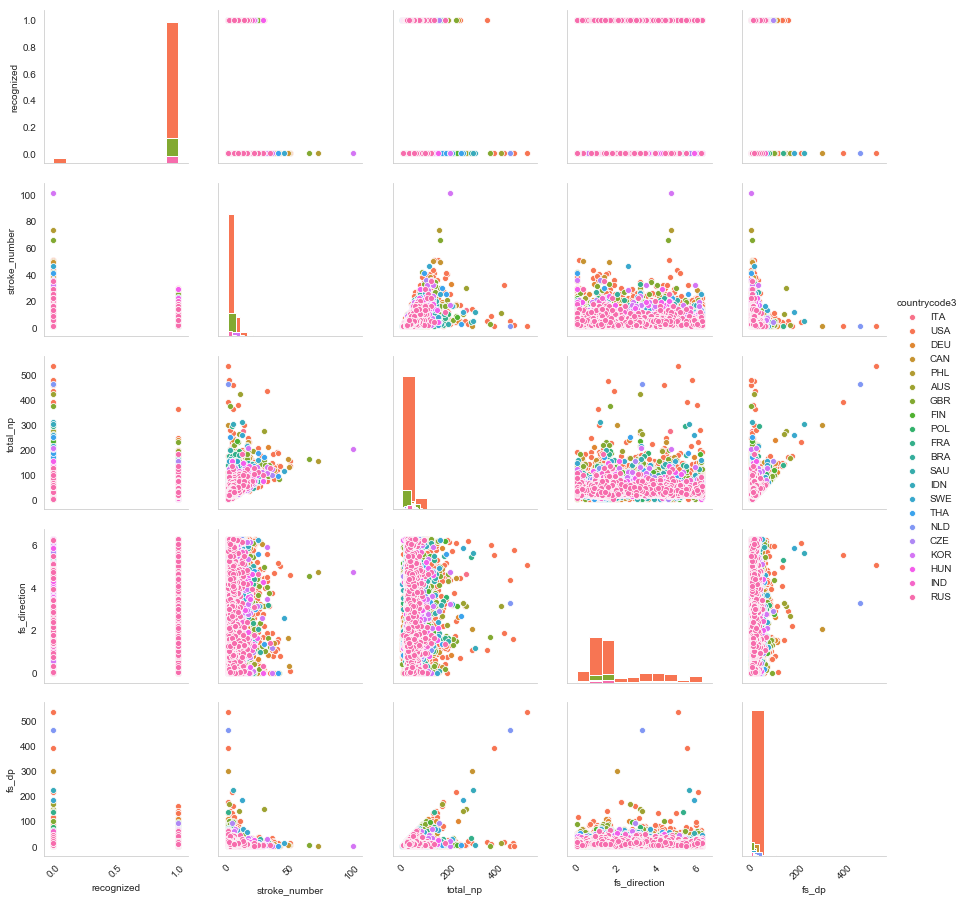

In [137]:
# Show a Pair Grid of the different features just created to have a summary and visual idea of the data
g = sns.pairplot(df_q2[['recognized','countrycode3', 'stroke_number', 'total_np','fs_direction', 'fs_dp']], hue="countrycode3", diag_kind="hist")
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

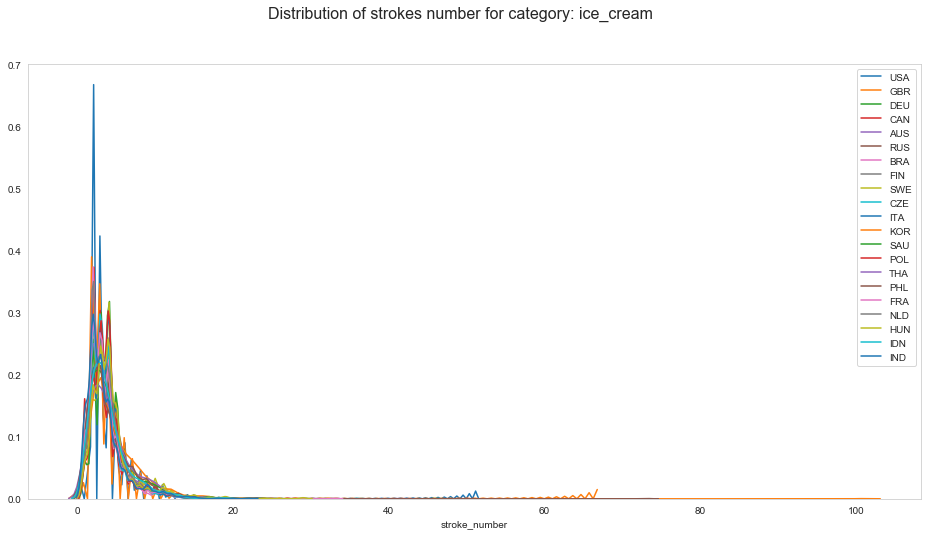

In [127]:
# Distribution of stroke number
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(16, 8)).suptitle("Distribution of strokes number for category: {}".format(category), fontsize=16)
for idx, ct in enumerate(main_countries):
    x=df_q2.loc[df_q2.countrycode3==ct,'stroke_number']
    #x=df_q2.loc[df_q2.countrycode==ct,'total_np']
    sns.distplot(x, hist=False, rug=False, label=ct);

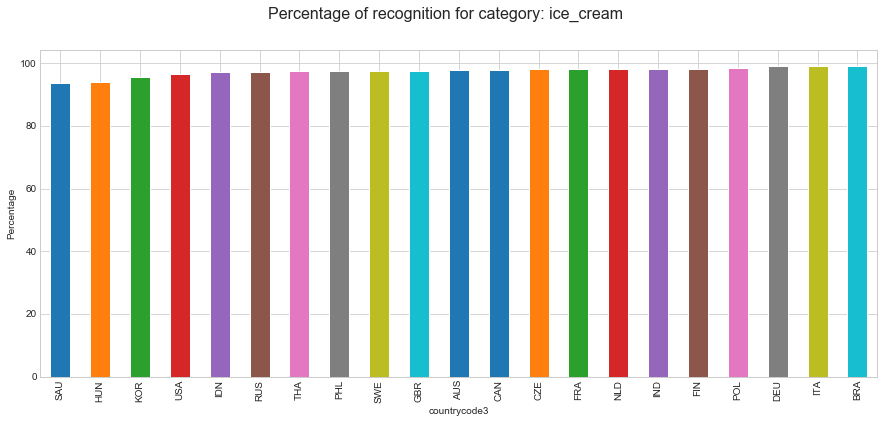

In [128]:
# Look at recognized rate per country
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(15, 6)).suptitle("Percentage of recognition for category: {}".format(category), fontsize=16)
    plt.ylabel('Percentage')
    (df_q2.groupby('countrycode3')['recognized'].mean()*100).sort_values().plot.bar()

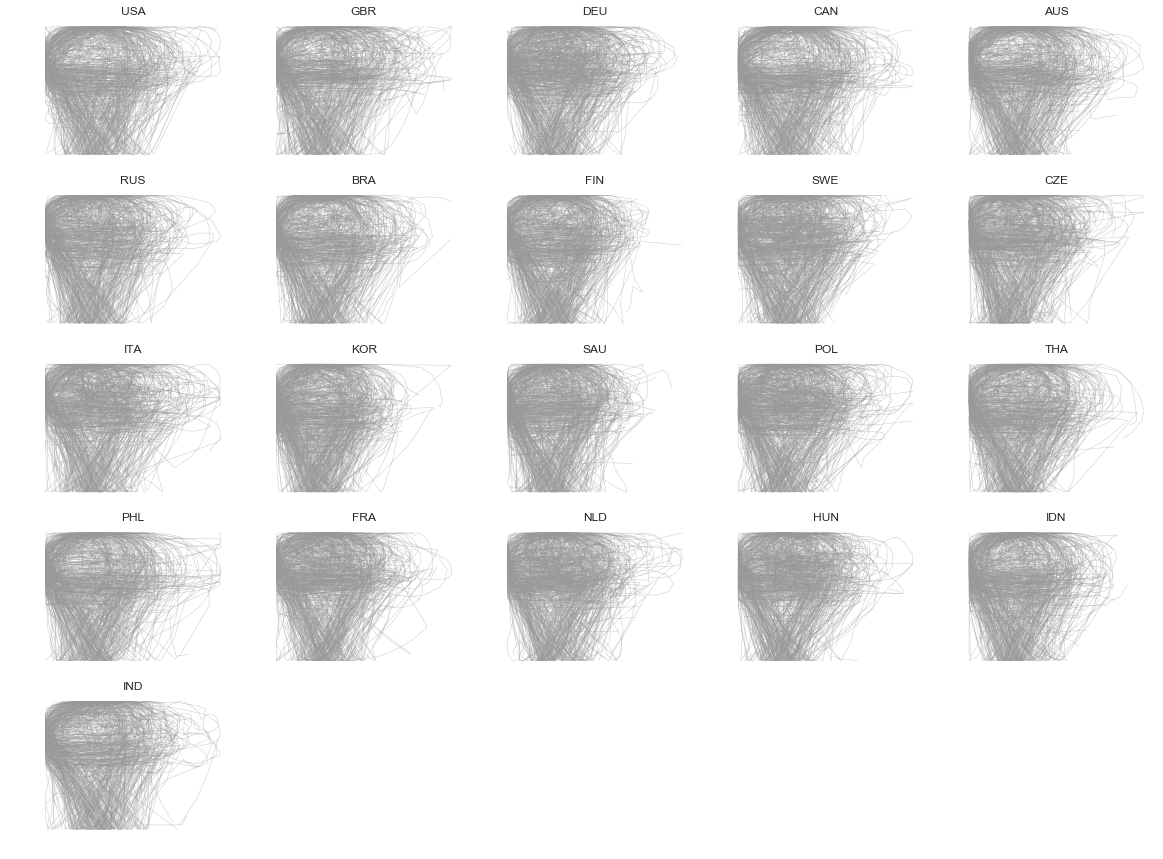

In [129]:
# Overlap Drawing for recognized drawings of our main countries
# this gives an idea of what the ML system recognize as an icecream
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20,15), sharex='col', sharey='row')
np.vectorize(lambda ax:ax.axis('off'))(ax)
i = 0
for j,country in enumerate(main_countries):
    d_recog = df_q2[(df_q2.countrycode3==country) & (df_q2.recognized==1)]
    drawings = d_recog.drawing.sample(n=150)
    for drawing in drawings:
        for strokes in drawing:
            ax[i,(j%5)].set_title(country)
            ax[i,(j%5)].plot(np.array(strokes[0]), -np.array(strokes[1]), color=(0.6, 0.6, 0.6), alpha=0.5, linewidth=0.5)
    i=int((j+1)/5)

In [130]:
# How many unrecognized drawing we have per country?
df_q2[df_q2.recognized==0].countrycode.value_counts()

US    1751
GB     214
SA     110
CA      96
KR      76
RU      74
HU      70
AU      60
SE      50
DE      43
TH      42
PH      40
CZ      38
FI      38
FR      30
ID      30
PL      28
NL      27
BR      22
IT      19
IN      19
Name: countrycode, dtype: int64

In [131]:
# Function to display a sample of non-recognized drawings for a country.
def draw_unrecognized(country):
    d_tmp = df_q2[(df_q2.countrycode==country) & (df_q2.recognized==0)]
    drawing_c = len(d_tmp.index)
    if drawing_c > 40:
        sample = 40
    else:
        sample = drawing_c     
    drawings = d_tmp.drawing.sample(n=sample)
    fig, ax = plt.subplots(nrows=8, ncols=5, figsize=(15,15), sharex='col', sharey='row')
    for i in range(8):
        for j in range(5):
            try:
                for strokes in drawings.iloc[i*5+j]:
                    # Each array has X coordinates at [0, :] and Y coordinates at [1, :].
                    ax[i,j].axis('off')
                    ax[i,j].plot(np.array(strokes[0]), -np.array(strokes[1]), color='black')
            except:
                    ax[i,j].axis('off')

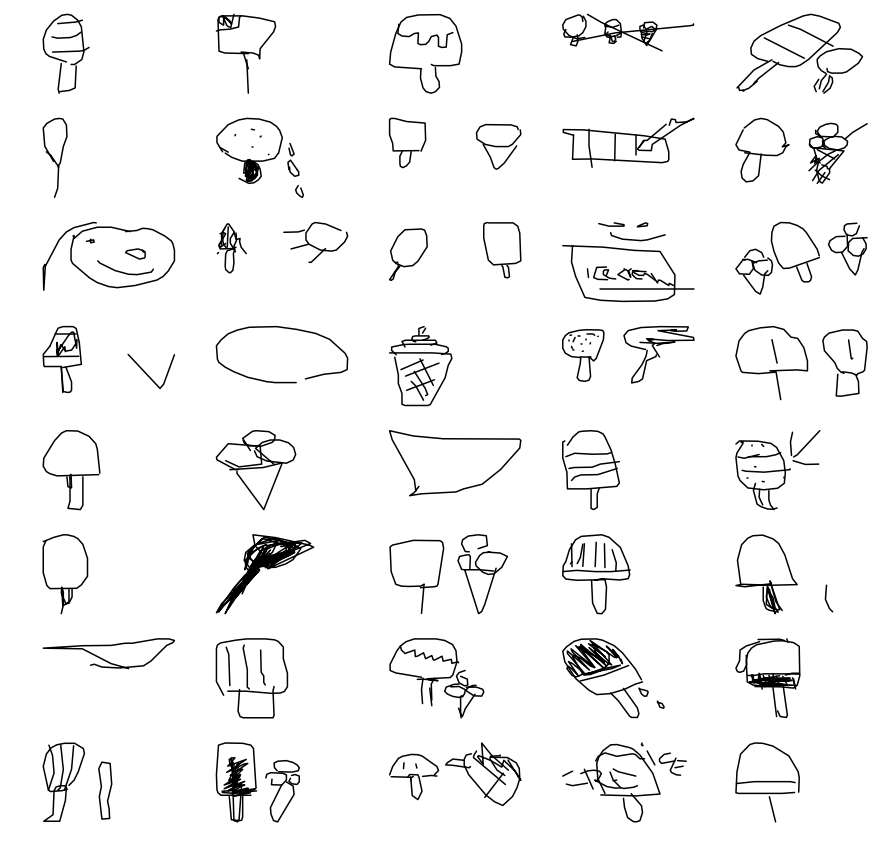

In [138]:
draw_unrecognized('HU')